# Exothermic CSTR

Keywords: Simulator, dae, differential-algebraic equations, ipopt usage

```{index} Simulator
```

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))
    
from pyomo.environ import *
from pyomo.dae import *
from pyomo.dae.simulator import Simulator

## Description

This example is intended as an introduction to the nonlinear dynamics of an exothermic continuous stirred-tank reactor. The example has been studied by countless researchers and students since the pioneering work of Amundson and Aris in the 1950's. The particular formulation and parameter values described below are taken from example 2.5 from Seborg, Edgar, Mellichamp and Doyle (SEMD).

![Agitated_vessel.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/Agitated_vessel.png?raw=1)

(Diagram By <a href="//commons.wikimedia.org/wiki/User:Daniele_Pugliesi" title="User:Daniele Pugliesi">Daniele Pugliesi</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="http://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=6915706">Link</a>)

## Arrehenius law kinetics for a first-order reaction

We assume the kinetics are dominated by a single first order reaction

$$A \xrightarrow{kc_A}{} \text{Products}$$

The reaction rate per unit volume is modeled as the product $kc_A$ where $c_A$ is the concentration of $A$. The rate constant $k(T)$ is a increases with temperature following the Arrehenius law

$$k(t) = k_0 e^{-\frac{E_a}{RT}}$$

$E_a$ is the activation energy, $R$ is the gas constant, $T$ is absolute temperature, and $k_0$ is the pre-exponential factor. 

We can see the strong temperature dependence by plotting $k(T)$ versus temperature over typical operating conditions.

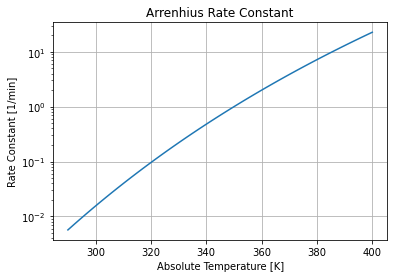

In [2]:
Ea  = 72750     # activation energy J/gmol
R   = 8.314     # gas constant J/gmol/K
k0  = 7.2e10    # Arrhenius rate constant 1/min

T = np.linspace(290,400)

# Arrhenius rate expression
def k(T):
    return k0*np.exp(-Ea/R/T)

plt.semilogy(T,k(T))
plt.xlabel('Absolute Temperature [K]')
plt.ylabel('Rate Constant [1/min]')
plt.title('Arrenhius Rate Constant')
plt.grid(True)

This graph shows the reaction rate changes by three orders of magnitude over the range of possible operating temperatures. Because an exothermic reaction releases heat faster at higher temperatures, there is a positive feedback that can potentially result in unstable process behavior.

## Modeling and parameter values

### Mathematical model

The model consists of mole and energy balances on the contents of the well-mixed reactor.

$$
\begin{align*}
V\frac{dc_A}{dt} & = q(c_{Ai}-c_A)-Vkc_A \\
V\rho C_p\frac{dT}{dt} & = wC_p(T_i-T) + (-\Delta H_R)Vkc_A + UA(T_c-T)
\end{align*}
$$

which are the equations that will be integrated below.

|Quantity | Symbol | Value | Units | Comments |
|:-------|:----:|:---:|:----|:--- |
|Activation Energy | $E_a$ | 72,750 | J/gmol | |
|Arrehnius pre-exponential | $k_0$ | 7.2 x 10<sup>10</sup> | 1/min | |
|Gas Constant | $R$ | 8.314 | J/gmol/K | |
|Reactor Volume | $V$ | 100 | liters | |
|Density | $\rho$ | 1000 | g/liter | |
|Heat Capacity | $C_p$ | 0.239 | J/g/K | |
|Enthalpy of Reaction | $\Delta H_r$ | -50,000 | J/gmol | |
|Heat Transfer Coefficient | $UA$ | 50,000 | J/min/K | |
|Feed flowrate | $q$ | 100 | liters/min | |
|Feed concentration | $c_{A,f}$ | 1.0 | gmol/liter | |
|Feed temperature | $T_f$ | 350 | K | |
|Initial concentration | $c_{A,0}$ | 0.5 | gmol/liter | |
|Initial temperature | $T_0$ | 350 | K | |
|Coolant temperature | $T_c$ | 300 | K | Primary Manipulated Variable |


### Pyomo model

In [3]:
Ea  = 72750     # activation energy J/gmol
R   = 8.314     # gas constant J/gmol/K
k0  = 7.2e10    # Arrhenius rate constant 1/min
V   = 100.0     # Volume [L]
rho = 1000.0    # Density [g/L]
Cp  = 0.239     # Heat capacity [J/g/K]
dHr = -5.0e4    # Enthalpy of reaction [J/mol]
UA  = 5.0e4     # Heat transfer [J/min/K]
q   = 100.0     # Flowrate [L/min]
cAi = 1.0       # Inlet feed concentration [mol/L]
Ti  = 350.0     # Inlet feed temperature [K]
cA0 = 0.5       # Initial concentration [mol/L]
T0  = 350.0     # Initial temperature [K]
Tc  = 300.0     # Coolant temperature [K]

def cstr(cA0 = 0.5, T0 = 350.0):
    m = ConcreteModel()
    m.t = ContinuousSet(bounds=(0.0, 10.0))
    m.cA = Var(m.t)
    m.T = Var(m.t)
    m.dcA = DerivativeVar(m.cA)
    m.dT = DerivativeVar(m.T)

    # Setting the initial conditions
    m.cA[0.0].fix(cA0)
    m.T[0.0].fix(T0)
    
    def k(T):
        return k0*exp(-Ea/R/T)
    
    @m.Constraint(m.t)
    def ode1(m, t):
        return V*m.dcA[t] == q*(cAi - m.cA[t]) - V*k(m.T[t])*m.cA[t]
    
    @m.Constraint(m.t)
    def ode2(m, t):
        return V*rho*Cp*m.dT[t] == q*rho*Cp*(Ti - m.T[t]) + (-dHr)*V*k(m.T[t])*m.cA[t] + UA*(Tc - m.T[t])

    return m

## Simulation and visualization

### Visualization function

In [4]:
# visualization function plots concentration and temperature
def cstr_plot(t, y, ax=[]):
    if len(ax) == 0:
        fig = plt.figure(figsize=(12, 8))

        ax1 = plt.subplot(2, 2, 1)
        ax1.set_xlabel('Time [min]')
        ax1.set_ylabel('Concentration [gmol/liter]')
        ax1.set_title('Concentration')
        ax1.set_ylim(0, 1)
        ax1.grid(True)
    
        ax2 = plt.subplot(2, 2, 2);
        ax2.set_xlabel('Time [min]')
        ax2.set_ylabel('Temperature [K]');
        ax2.set_title('Temperature')
        ax2.set_ylim(300, 450)
        ax2.grid(True)
        
        ax3 = plt.subplot(2, 2, 3);
        ax3.set_xlabel('Concentration [gmol/liter]')
        ax3.set_ylabel('Temperature [K]');
        ax3.set_xlim(0, 1)
        ax3.set_ylim(300, 450)
        ax3.grid(True)
        
    else:
        ax1, ax2, ax3 = ax
        
    ax1.plot(t, y[:, 0], label=str(Tc))
    ax1.legend()
    ax2.plot(t, y[:, 1], label=str(Tc))
    ax2.legend()
    ax3.plot(y[0, 0], y[0, 1], 'r.', ms=20)
    ax3.plot(y[:, 0], y[:, 1], lw=2, label=str(Tc))
    ax3.legend()
    return [ax1, ax2, ax3]

### Simulation

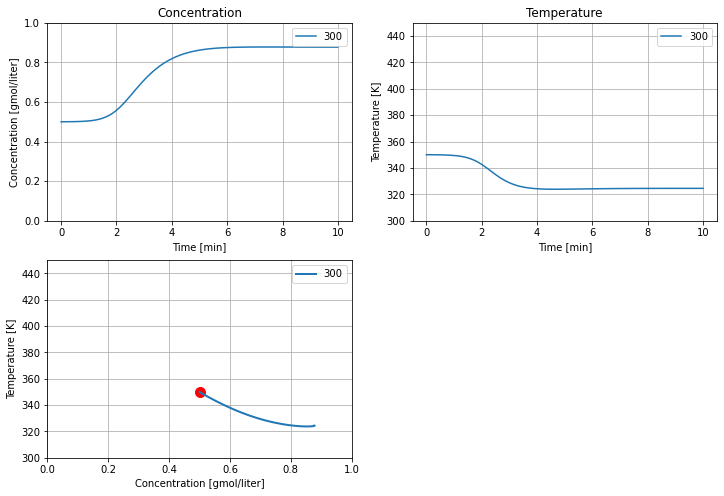

In [5]:
Tc = 300
tsim, profiles = Simulator(cstr(), package='scipy').simulate(numpoints=100)
cstr_plot(tsim, profiles);

## Effect of cooling temperature

The primary means of controlling the reactoris through temperature of the cooling water jacket. The next calculations explore the effect of plus or minus change of 5 K in cooling water temperature on reactor behavior. These simulations reproduce the behavior shown in Example 2.5 SEMD.

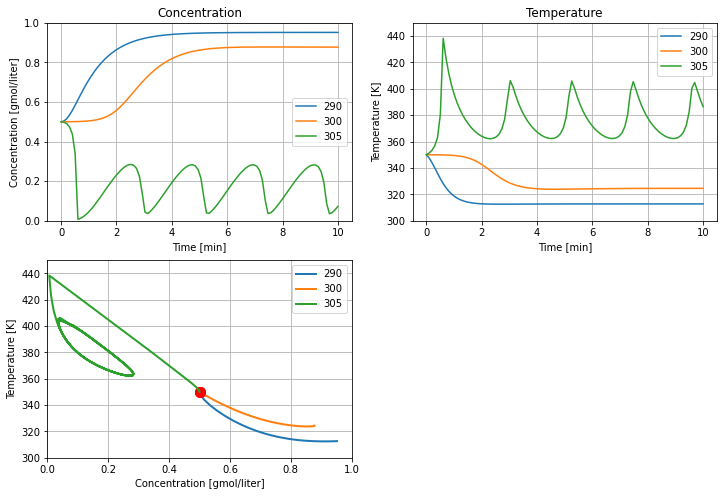

In [6]:
ax = []
for Tc in [290, 300, 305]:
    tsim, profiles = Simulator(cstr(), package='scipy').simulate(numpoints=100)
    ax  = cstr_plot(tsim, profiles, ax)

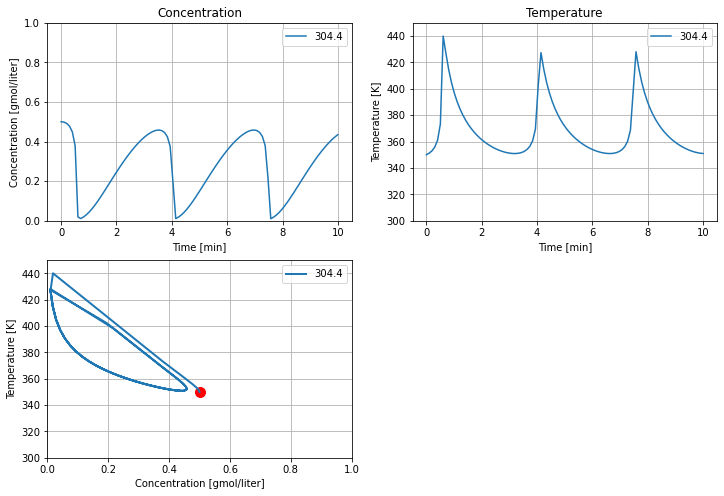

In [7]:
#@title CSTR Simulation { run: "auto", vertical-output: true }
T_cooling = 304.4 #@param {type:"slider", min:290, max:305, step:0.1}
ax = []
Tc = T_cooling
tsim, profiles = Simulator(cstr(), package='scipy').simulate(numpoints=100)
ax  = cstr_plot(tsim, profiles, ax);